In [1]:
import os
import torch
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!gdown https://drive.google.com/uc?id=1I64DYabWlUU4D4ktAS8IMSrQxlaGJIKi

Downloading...
From: https://drive.google.com/uc?id=1I64DYabWlUU4D4ktAS8IMSrQxlaGJIKi
To: /content/Dataset_Student.zip
100% 9.98G/9.98G [01:17<00:00, 129MB/s]


In [3]:
!unzip Dataset_Student.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_Student/unlabeled/video_12094/image_13.png  
  inflating: Dataset_Student/unlabeled/video_12094/image_14.png  
  inflating: Dataset_Student/unlabeled/video_12094/image_15.png  
  inflating: Dataset_Student/unlabeled/video_12094/image_16.png  
  inflating: Dataset_Student/unlabeled/video_12094/image_17.png  
  inflating: Dataset_Student/unlabeled/video_12094/image_18.png  
  inflating: Dataset_Student/unlabeled/video_12094/image_19.png  
  inflating: Dataset_Student/unlabeled/video_12094/image_20.png  
  inflating: Dataset_Student/unlabeled/video_12094/image_21.png  
   creating: Dataset_Student/unlabeled/video_12096/
  inflating: Dataset_Student/unlabeled/video_12096/image_0.png  
  inflating: Dataset_Student/unlabeled/video_12096/image_1.png  
  inflating: Dataset_Student/unlabeled/video_12096/image_2.png  
  inflating: Dataset_Student/unlabeled/video_12096/image_3.png  
  inflating: Dataset_Student/unlabeled/vide

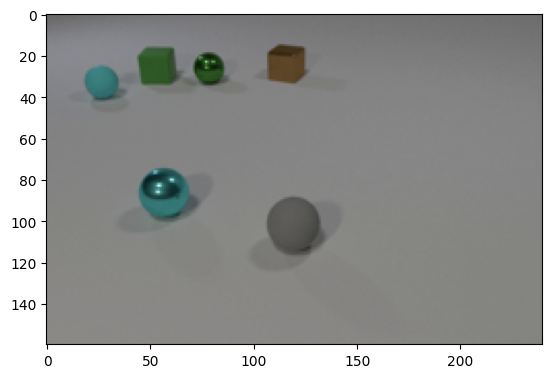

In [4]:
plt.imshow(iio.imread("/content/Dataset_Student/train/video_0/image_21.png"))

In [5]:
mask = np.load("/content/Dataset_Student/train/video_0/mask.npy")

In [6]:
mask.shape

(22, 160, 240)

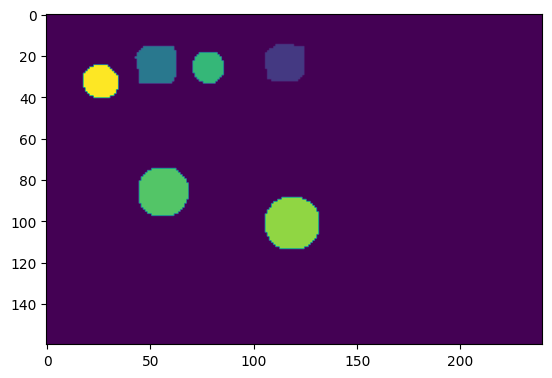

In [7]:
plt.imshow(mask[21])

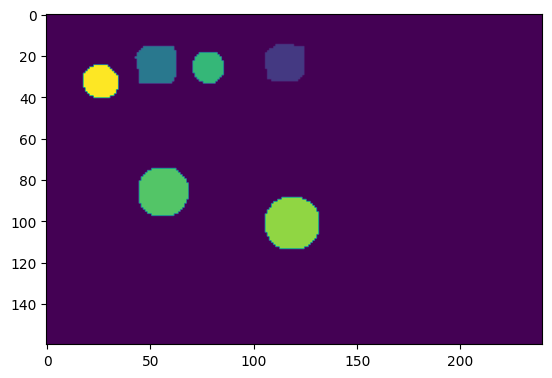

In [8]:
mask = np.load("/content/Dataset_Student/train/video_0/mask.npy")

plt.imshow(mask[-1])

In [9]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 1.6 MB/s eta 0:00:00


In [10]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49)

In [11]:
jaccard(torch.Tensor(mask[0]), torch.Tensor(mask[0]))

tensor(0.1429)

##Data

In [12]:
import os

masks = []
for path in os.listdir("/content/Dataset_Student/train/"):
  masks.append(np.load(f"/content/Dataset_Student/train/{path}/mask.npy"))

masks = torch.tensor(masks)

<ipython-input-12-3a2320859418>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  masks = torch.tensor(masks)


In [13]:
val_masks = []
for path in os.listdir("/content/Dataset_Student/val/"):
  val_masks.append(np.load(f"/content/Dataset_Student/val/{path}/mask.npy"))

val_masks = torch.tensor(val_masks)

In [14]:
print(masks.shape)
print(val_masks.shape)

torch.Size([1000, 22, 160, 240])
torch.Size([1000, 22, 160, 240])


In [31]:
torch.save(masks, 'masks.pt')
torch.save(val_masks, 'val_masks.pt')

In [15]:
#@title Imports
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler

# Torchvision
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.transforms as T

In [16]:
mean = masks.to(torch.float32).mean().item()
std = masks.to(torch.float32).std().item()
print("MEAN: ", mean)
print("STDev:", std)

MEAN:  1.2171642780303955
STDev: 6.229452133178711


In [17]:
#@title Dataset Class & Loaders
class MaskDataset(Dataset):
  def __init__(self, data, transform=None):
    self.msks = data
    self.transform = transform
  
  def __len__(self):
    return len(self.msks)
  
  def __getitem__(self, index):
    msk = self.msks[index]

    if self.transform:
      msk = self.transform(msk.to(torch.float32))

    return msk

# Datasets
train_dataset = MaskDataset(masks,
                                  transform=transforms.Compose([
                                              T.Normalize(mean=mean, std=std)
                                           ])
                                  )

val_dataset = MaskDataset(val_masks,
                                  transform=transforms.Compose([
                                              T.Normalize(mean=mean, std=std)
                                           ])
                                  )

# test_dataset = MaskDataset(test_set,
#                                   transform=transforms.Compose([
#                                               T.Normalize(mean=mean, std=std)
#                                            ])
#                                   )

batch_size = 64

# Data Loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size)

# test_loader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=batch_size)

In [18]:
for ex in train_loader:
  print(ex.shape)
  break

torch.Size([64, 22, 160, 240])


##Model

In [19]:
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

device = None #torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

None


In [20]:
#@title Reducer
class Reducer(nn.Module):
    def __init__(self, in_chan, out_size=512):
      super().__init__()
      self.out_size = out_size
      out_1 = 4
      out_2 = 8
      out_3 = 16

      self.conv1 = nn.Conv2d(in_chan, out_1*in_chan, kernel_size=3, stride=2)
      self.act1 = nn.GELU()
      self.bn1 = nn.BatchNorm2d(out_1*in_chan)

      self.conv2 = nn.Conv2d(out_1*in_chan, out_2*in_chan, kernel_size=3, stride=2)
      self.act2 = nn.GELU()
      self.bn2 = nn.BatchNorm2d(out_2*in_chan)

      self.conv3 = nn.Conv2d(out_2*in_chan, out_3*in_chan, kernel_size=3, stride=2)
      self.act3 = nn.GELU()
      self.bn3 = nn.BatchNorm2d(out_3*in_chan)

      self.flat = nn.Flatten(start_dim=1)
      self.fc1 = nn.Linear(8816, out_size)

    def forward(self, x):
      batch_size = x.shape[0]

      check = True
      for i in range(11): # Process and reduce each image in sequence
        temp = x[:, i, :, :].reshape([-1, 1, 160, 240])
        temp = self.conv1(temp)
        temp = self.act1(temp)
        temp = self.bn1(temp)

        temp = self.conv2(temp)
        temp = self.act2(temp)
        temp = self.bn2(temp)

        temp = self.conv3(temp)
        temp = self.act3(temp)
        temp = self.bn3(temp)

        temp = self.flat(temp)
        temp = self.fc1(temp).reshape([batch_size, -1, self.out_size])

        if check:
          out = temp
          check = False
        else:
          out = torch.cat((out, temp), dim=1)

      return out

In [21]:
#@title Embeddings
def create_sinusoidal_embeddings(nb_p, dim, E):
    theta = np.array([
        [p / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)]
        for p in range(nb_p)
    ])
    E[:, 0::2] = torch.FloatTensor(np.sin(theta[:, 0::2]))
    E[:, 1::2] = torch.FloatTensor(np.cos(theta[:, 1::2]))
    E.requires_grad = False
    # print(E.shape)
    E = E.to(device)

class Embedding(nn.Module):
    def __init__(self, in_channels, embed_dim=256):
      # TODO
      super().__init__()
      self.embed_dim = embed_dim
      self.N = 11 # Number of images - may have misunderstood this

      self.position_embeddings = nn.Embedding(self.N, self.embed_dim)
      create_sinusoidal_embeddings(
          nb_p=self.N,
          dim=self.embed_dim,
          E=self.position_embeddings.weight.detach()
      )

      self.LayerNorm = nn.LayerNorm(self.embed_dim, eps=1e-12) # Remove?

    def forward(self, x):
      seq_length = x.size(1)
      positions = torch.arange(seq_length, dtype=torch.long, device=x.device) # (max_seq_length)

      emb = x[:, :, 0]
      position_ids = positions.unsqueeze(0).expand_as(emb)                      # (bs, max_seq_length)
      
      # Get img embeddings for each input id
      img_embeddings = x                                                # (bs, max_seq_length, dim)
      
      # Get position embeddings for each position id 
      position_embeddings = self.position_embeddings(position_ids)        # (bs, max_seq_length, dim)
      
      # Add them both 
      embeddings = img_embeddings + position_embeddings  # (bs, max_seq_length, dim)
      
      # Layer norm 
      embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)

      return x

In [22]:
#@title MHA
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
      # TODO
      super().__init__()
      self.num_heads = num_heads
      self.embed_dim = embed_dim

      d_x = embed_dim
          
      # Make sure that the embedding dimension of model is a multiple of number of heads
      assert embed_dim % self.num_heads == 0

      self.d_k = embed_dim // self.num_heads
      
      # These are still of dimension d_model. They will be split into number of heads 
      self.W_q = nn.Linear(d_x, embed_dim, bias=False)
      self.W_k = nn.Linear(d_x, embed_dim, bias=False)
      self.W_v = nn.Linear(d_x, embed_dim, bias=False)
      
      # Outputs of all sub-layers need to be of dimension d_model
      self.W_h = nn.Linear(embed_dim, embed_dim)

    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0) 
        k_length = K.size(-2) 
        
        # Scaling by d_k so that the soft(arg)max doesnt saturate
        Q = Q / np.sqrt(self.d_k)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2,3))          # (bs, n_heads, q_length, k_length)
        
        A = nn.Softmax(dim=-1)(scores)   # (bs, n_heads, q_length, k_length)
        
        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head)

        return H, A 

        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k)
        """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads times d_k))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)

    def forward(self, x):
      # TODO
      batch_size = x.shape[0]

      # After transforming, split into num_heads 
      Q = self.split_heads(self.W_q(x), batch_size)  # (bs, n_heads, q_length, dim_per_head)
      K = self.split_heads(self.W_k(x), batch_size)  # (bs, n_heads, k_length, dim_per_head)
      V = self.split_heads(self.W_v(x), batch_size)  # (bs, n_heads, v_length, dim_per_head)
      
      # Calculate the attention weights for each of the heads
      H_cat, A = self.scaled_dot_product_attention(Q, K, V)
      
      # Put all the heads back together by concat
      H_cat = self.group_heads(H_cat, batch_size)    # (bs, q_length, dim)
      
      # Final linear layer  
      H = self.W_h(H_cat)          # (bs, q_length, dim)
      
      return H, A

In [23]:
#@title MLP
class MLP(nn.Module):
    def __init__(self, d_model, hidden_dim, p):
        super().__init__()
        self.k1convL1 = nn.Linear(d_model, hidden_dim)
        self.activation1 = nn.GELU()
        self.k1convL2 = nn.Linear(hidden_dim, d_model)

    def forward(self, x):
        x = self.k1convL1(x)
        x = self.activation1(x)
        x = self.k1convL2(x)

        return x

In [24]:
#@title Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout):
        # TODO
        super().__init__()

        self.mha = MultiHeadSelfAttention(embed_dim, num_heads)
        self.mlp = MLP(embed_dim, mlp_dim, dropout)

        self.layernorm1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)


    def forward(self, x):
        # TODO
        # Multi-head attention 
        attn_output, _ = self.mha(x)  # (batch_size, input_seq_len, d_model)
        
        # Layer norm after adding the residual connection 
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        # Feed forward 
        mlp_output = self.mlp(out1)  # (batch_size, input_seq_len, d_model)
        
        #Second layer norm after adding residual connection 
        out2 = self.layernorm2(out1 + mlp_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [25]:
#@title Transformer
class VisionTransformer(nn.Module):
    def __init__(self, in_channels, embed_dim, num_heads, mlp_dim, num_layers, latent_dim, dropout=0.1):
        # TODO
        super().__init__()

        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.N = 11 # I think

        self.embedding = Embedding(in_channels, embed_dim)

        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(TransformerBlock(embed_dim, num_heads, mlp_dim, dropout))

        self.fc1 = nn.Linear(embed_dim*self.N, latent_dim)

    def forward(self, x):
        # TODO
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        x = x.flatten(1)

        x = self.fc1(x)

        return x  # (batch_size, input_seq_len, d_model)

In [26]:
#@title Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim
        out_chan = 1
        out_1 = 32
        out_2 = 16
        out_3 = 8
        out_4 = 4

        self.fc1 = nn.Linear(latent_dim, 8*latent_dim)
        self.A1 = nn.GELU()

        self.fc2 = nn.Linear(8*latent_dim, 64*latent_dim)
        self.A2 = nn.GELU()

        # Unflattening to 2D here in forward() function

        self.CT_1 = nn.ConvTranspose2d(32*out_chan, out_1*out_chan, kernel_size=3, output_padding=1, padding=(2, 3), stride=2)
        self.act1 = nn.GELU()
        self.bn1 = nn.BatchNorm2d(out_1*out_chan)

        self.CT_2 = nn.ConvTranspose2d(out_1*out_chan, out_2*out_chan, kernel_size=(3, 4), output_padding=1, padding=(3, 2), stride=(2, 3))
        self.act2 = nn.GELU()
        self.bn2 = nn.BatchNorm2d(out_2*out_chan)

        self.CT_3 = nn.ConvTranspose2d(out_2*out_chan, out_3*out_chan, kernel_size=3, output_padding=1, padding=2, stride=2)
        self.act3 = nn.GELU()
        self.bn3 = nn.BatchNorm2d(out_3*out_chan)

        self.CT_4 = nn.ConvTranspose2d(out_3*out_chan, out_4*out_chan, kernel_size=3, output_padding=1, padding=(4, 2), stride=3)
        self.act4 = nn.GELU()
        self.bn4 = nn.BatchNorm2d(out_4*out_chan)

        self.conv1 = nn.Conv2d(out_4*out_chan, out_chan, kernel_size=4, padding=0, stride=2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.A1(x)

        x = self.fc2(x)
        x = self.A2(x)

        x = x.reshape(x.shape[0], -1, 16, 16)

        x = self.CT_1(x)
        x = self.act1(x)
        x = self.bn1(x)

        x = self.CT_2(x)
        x = self.act2(x)
        x = self.bn2(x)

        x = self.CT_3(x)
        x = self.act3(x)
        x = self.bn3(x)

        x = self.CT_4(x)
        x = self.act4(x)
        x = self.bn4(x)

        x = self.conv1(x)

        return x

In [27]:
#@title Transformer AutoEncoder : Transcoder or Autoenformer or TAE
from tqdm.notebook import tqdm
class TAE(nn.Module):
    def __init__(self, in_channels, embed_dim, num_heads, mlp_dim, num_layers, latent_dim):
        super().__init__()
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.num_layers = num_layers
        self.latent_dim = latent_dim

        self.reducer = Reducer(in_channels, out_size=embed_dim)
        self.transformer = VisionTransformer(self.in_channels, 
                                             self.embed_dim, 
                                             self.num_heads, 
                                             self.mlp_dim, 
                                             self.num_layers, 
                                             self.latent_dim) 
        self.decoder = Decoder(self.latent_dim)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        x = self.reducer(x)
        x = self.transformer(x)
        x = self.decoder(x)

        return x

In [28]:
#@title Settings

in_channels = 1 # TODO
embed_dim = 256 # TODO
num_heads = 8 # TODO
mlp_dim = 512 # TODO
num_layers = 8 # TODO
latent_dim = 128 # TODO
dropout = 0.1 # TODO

batch_size = 64 # TODO

In [29]:
model = TAE(in_channels, embed_dim, num_heads, mlp_dim, num_layers, latent_dim).to(device)
input_tensor = masks[:2, :11, :, :].to(torch.float32).to(device)
output = model(input_tensor)
print(output.shape)

val = []

torch.Size([2, 1, 160, 240])


In [34]:
#@title Training
from tqdm.notebook import tqdm

num_epochs = 1
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss() #torchmetrics.JaccardIndex(task="multiclass", num_classes=70) # What is num_classes?

result = []
for epoch in tqdm(range(1, num_epochs+1), leave=False): # Train on several epochs
  for batch in tqdm(train_loader, leave=False):
    for i in tqdm(range(11-1), leave=False): # Generate next image 10 times (11 - 1)
      temp_X = batch[:, i:11+i, :, :].requires_grad_(True)

      pred = model.forward(temp_X) # Make prediction on next image using last 11 images
      targ = batch[:, 11+i, :, :].reshape([-1, 1, 160, 240]).requires_grad_(True) # Target is the next mask

      loss = criterion(pred, targ)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

  # Test best model on validation and test set
  with torch.no_grad():
    val_result = 0

    count = 0
    for b in val_loader:
      v_temp = b[:, :11, :, :]
      v_pred = model.forward(v_temp) # Make prediction on next image using last 11 images
      v_targ = b[:, 11, :, :] # Target is the next mask
      val_result += criterion(v_pred, v_targ)
      if count > 1:
        break
      count += 1

    result.append(val_result.item())
    print("Epoch", epoch, "| VAL:", round(val_result.item(), 2))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 | VAL: 3.16


##Results

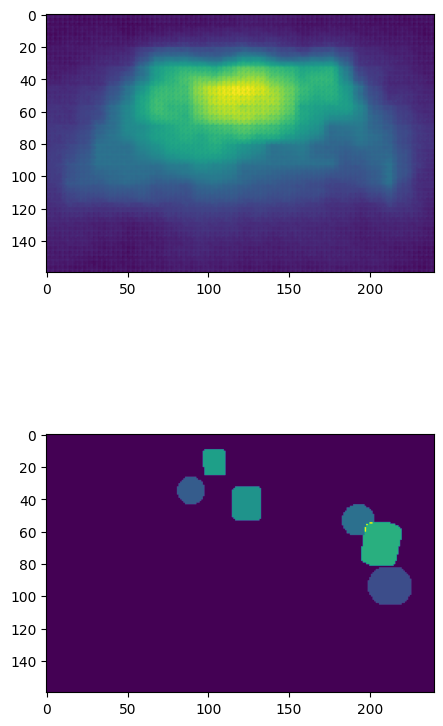

In [35]:
ind = 1
for ex in val_loader:
  x_ = ex[:, :11, :, :]
  pred_ = model.forward(x_).detach().numpy()
  targ_ = ex[:, 11, :, :]

  fig, axs = plt.subplots(nrows=2, figsize=(5, 10))
  axs[0].imshow(pred_[ind][0])
  axs[1].imshow(targ_[ind])
  plt.show()
  break